# 情報システム実習論　テキスト分析課題2A
### 必要なライブラリ、データセットのインポート

In [43]:
!pip install pandas
!pip install nltk
!pip install gensim
!pip install pyLDAvis

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import collections
from gensim import models
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import collections
from gensim import models
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

### nltkが使えるようにしておく

In [45]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("reuters")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /Users/kento/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kento/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to /Users/kento/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kento/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### データを取得と前処理

In [46]:
from nltk.corpus import reuters as corpus

In [47]:
for n,item in enumerate(corpus.words(corpus.fileids()[0])[:300]):
    print(item, end=" ")
    if (n%25) ==24:
      print(" ")

ASIAN EXPORTERS FEAR DAMAGE FROM U . S .- JAPAN RIFT Mounting trade friction between the U . S . And Japan has raised fears  
among many of Asia ' s exporting nations that the row could inflict far - reaching economic damage , businessmen and officials said . They  
told Reuter correspondents in Asian capitals a U . S . Move against Japan might boost protectionist sentiment in the U . S . And  
lead to curbs on American imports of their products . But some exporters said that while the conflict would hurt them in the long -  
run , in the short - term Tokyo ' s loss might be their gain . The U . S . Has said it will  
impose 300 mln dlrs of tariffs on imports of Japanese electronics goods on April 17 , in retaliation for Japan ' s alleged failure to  
stick to a pact not to sell semiconductors on world markets at below cost . Unofficial Japanese estimates put the impact of the tariffs at  
10 billion dlrs and spokesmen for major electronics firms said they would virtually halt exports 

###  前から1000文書を用いて分析を行う

In [48]:
k=1000
docs=[corpus.words(fileid) for fileid in corpus.fileids()[:k]]

In [91]:
#ストップワードリストの作成

#1 nltkのストップワードリスト
en_stop = nltk.corpus.stopwords.words('english')

# 一度LDAしてみる等して，適宜ノイズになってそうな記号等を見つけて，ストップワードリストに新たに加える
#　LDAを何回か回して出てきた数値や、"last","month"という単語をストップワードリストに追加した。
en_stop= ["``","/",",.",".,",";","--",":",")","(",'"','&',"'",'),',',"','-','.,','.,"','.-',"?",">","<"]                  \
         +["0","1","2","3","03","4","04","5","6","7","8","9","09","10","11","12","86","87","1986","1987","000"]                                                      \
         +["said","say","u","v","mln","ct","net","dlrs","tonne","pct","shr","nil","company","lt","share","year","billion","price","last","month"]          \
         +en_stop

In [92]:
#前処理関数の作成

from nltk.corpus import wordnet as wn #lemmatize関数のためのimport

def preprocess_word(word, stopwordset):
    
    #1.make words lower  example: Python =>python
    word=word.lower()
    
    #2.remove "," and "."
    if word in [",","."]:
        return None
    
    #3.remove stopword  example: the => (None) 
    if word in stopwordset:
        return None
    
    #4.lemmatize  example: cooked=>cook
    lemma = wn.morphy(word)
    if lemma is None:
        return word

    elif lemma in stopwordset: #lemmatizeしたものがstopwordである可能性がある
        return None
    else:
        return lemma
    

def preprocess_document(document):
    document=[preprocess_word(w, en_stop) for w in document]
    document=[w for w in document if w is not None]
    return document

def preprocess_documents(documents):
    return [preprocess_document(document) for document in documents]

## LDA準備

In [93]:
import gensim
from gensim import corpora

In [94]:
#documentを，gensim LDAが読み込めるデータ構造にする

#辞書の作成
dictionary = corpora.Dictionary(preprocess_documents(docs))
#コーパスの作成
corpus_ = [dictionary.doc2bow(doc) for doc in preprocess_documents(docs)]

In [95]:
#Dictionary:gensimにおける辞書クラス
#token2id属性には単語と辞書IDとの対応が格納される

print(dictionary.token2id)

': 6846, 'shall': 6847, 'tat': 6848, 'thatcher': 6849, 'timetable': 6850, 'tit': 6851, 'unfortunate': 6852, '50586': 6853, '51953': 6854, '79348': 6855, '95913': 6856, 'arabian': 6857, 'sama': 6858, 'kampala': 6859, 'kenyan': 6860, 'lent': 6861, 'mombasa': 6862, 'museveni': 6863, 'penalty': 6864, 'remittance': 6865, 'thinking': 6866, 'uganda': 6867, 'ugandan': 6868, 'unhappy': 6869, 'vision': 6870, 'wagon': 6871, 'yoweri': 6872, '643': 6873, 'confectionery': 6874, 'grind': 6875, 'taw': 6876, 'bicol': 6877, 'dominguez': 6878, 'hectarage': 6879, 'negligible': 6880, 'palay': 6881, 'unmilled': 6882, '465': 6883, 'appetite': 6884, 'cooling': 6885, 'dampen': 6886, 'fekete': 6887, 'forint': 6888, 'hungarian': 6889, 'hungary': 6890, 'janos': 6891, 'mti': 6892, 'overheat': 6893, 'poland': 6894, 'refrigerator': 6895, 'style': 6896, 'triple': 6897, 'unrest': 6898, 'barter': 6899, 'consulate': 6900, 'ding': 6901, 'pakistani': 6902, 'tian': 6903, 'anz': 6904, 'anza': 6905, 'backdrop': 6906, 'false'

### LDA学習

In [96]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus_,
                                           num_topics=20,
                                           id2word=dictionary,
                                           alpha=0.1,                             #optional LDAのハイパーパラメータalpha
                                           eta=0.1,                                 #optional LDAのハイパーパラメータbeta
                                           #minimum_probability=0.0    #optional 学習結果に格納するトピック・単語の生起確率の下限
                                          )

### パラメータの確認

In [97]:
#(トピックID, 当該トピックにおける単語とそのprobability)  ※　のうち、上位num_words位 

topics = ldamodel.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.007*"inc" + 0.006*"export" + 0.005*"15" + 0.005*"trade" + 0.004*"crop" + 0.004*"dome" + 0.004*"1985" + 0.004*"ltd" + 0.004*"corp" + 0.004*"13" + 0.004*"qtr" + 0.004*"report" + 0.004*"loan" + 0.004*"estimate" + 0.003*"market"')
(1, '0.008*"profit" + 0.006*"tax" + 0.005*"week" + 0.004*"oil" + 0.004*"stg" + 0.004*"one" + 0.004*"qtr" + 0.004*"inc" + 0.004*"end" + 0.004*"loss" + 0.004*"paris" + 0.004*"28" + 0.003*"march" + 0.003*"agreement" + 0.003*"meeting"')
(2, '0.009*"would" + 0.004*"sales" + 0.004*"inc" + 0.003*"stock" + 0.003*"note" + 0.003*"economic" + 0.003*"trade" + 0.003*"13" + 0.003*"analyst" + 0.003*"exchange" + 0.003*"import" + 0.002*"march" + 0.002*"april" + 0.002*"include" + 0.002*"plant"')
(3, '0.005*"qtr" + 0.004*"figure" + 0.004*"trade" + 0.004*"new" + 0.004*"co" + 0.004*"export" + 0.004*"also" + 0.004*"report" + 0.003*"marks" + 0.003*"corp" + 0.003*"would" + 0.003*"import" + 0.003*"february" + 0.003*"monthly" + 0.003*"1st"')
(4, '0.007*"quarter" + 0.006*"oil" + 0.0

In [98]:
#[(当該documentにおけるトピックIDとそのprobability　)]　 ※　のうち、minimum_probabilityの値を超えるもの

for n,item in enumerate(corpus_[:10]):
    print("document ID "+str(n)+":" ,end="")
    print(ldamodel.get_document_topics(item))

document ID 0:[(6, 0.030022345), (14, 0.14442672), (18, 0.82137555)]
document ID 1:[(8, 0.96664524)]
document ID 2:[(7, 0.7882043), (10, 0.19570945)]
document ID 3:[(4, 0.085611515), (13, 0.80028766), (18, 0.0960043)]
document ID 4:[(4, 0.13005602), (9, 0.16516177), (17, 0.6875812)]
document ID 5:[(1, 0.678859), (5, 0.30519572)]
document ID 6:[(7, 0.0417103), (17, 0.9505884)]
document ID 7:[(5, 0.9405989)]
document ID 8:[(18, 0.9728406)]
document ID 9:[(14, 0.9948469)]


In [99]:
#documentのcategory
categories=[corpus.categories(fileid) for fileid in corpus.fileids()]

In [100]:
n=0

#n番目のdocumentのトピック分布
print(ldamodel.get_document_topics(corpus_[n]))

#n番目のdocumentのcategory
print(categories[n])

#n番目のdocumentの生の文章
print(" ".join(docs[n]))

[(6, 0.026278688), (14, 0.14694005), (18, 0.82260585)]
['trade']
ASIAN EXPORTERS FEAR DAMAGE FROM U . S .- JAPAN RIFT Mounting trade friction between the U . S . And Japan has raised fears among many of Asia ' s exporting nations that the row could inflict far - reaching economic damage , businessmen and officials said . They told Reuter correspondents in Asian capitals a U . S . Move against Japan might boost protectionist sentiment in the U . S . And lead to curbs on American imports of their products . But some exporters said that while the conflict would hurt them in the long - run , in the short - term Tokyo ' s loss might be their gain . The U . S . Has said it will impose 300 mln dlrs of tariffs on imports of Japanese electronics goods on April 17 , in retaliation for Japan ' s alleged failure to stick to a pact not to sell semiconductors on world markets at below cost . Unofficial Japanese estimates put the impact of the tariffs at 10 billion dlrs and spokesmen for major electr

### 可視化

In [101]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [102]:
#全documentを学習に用いた場合結構時間がかかる(20min~)
#gensimではK個のトピックに0~K-1のidが割り振られていたのに対し，pyLDAvisでは1~Kのidが割り振られていることに注意

lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus_, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [103]:
!pip install wordcloud

20


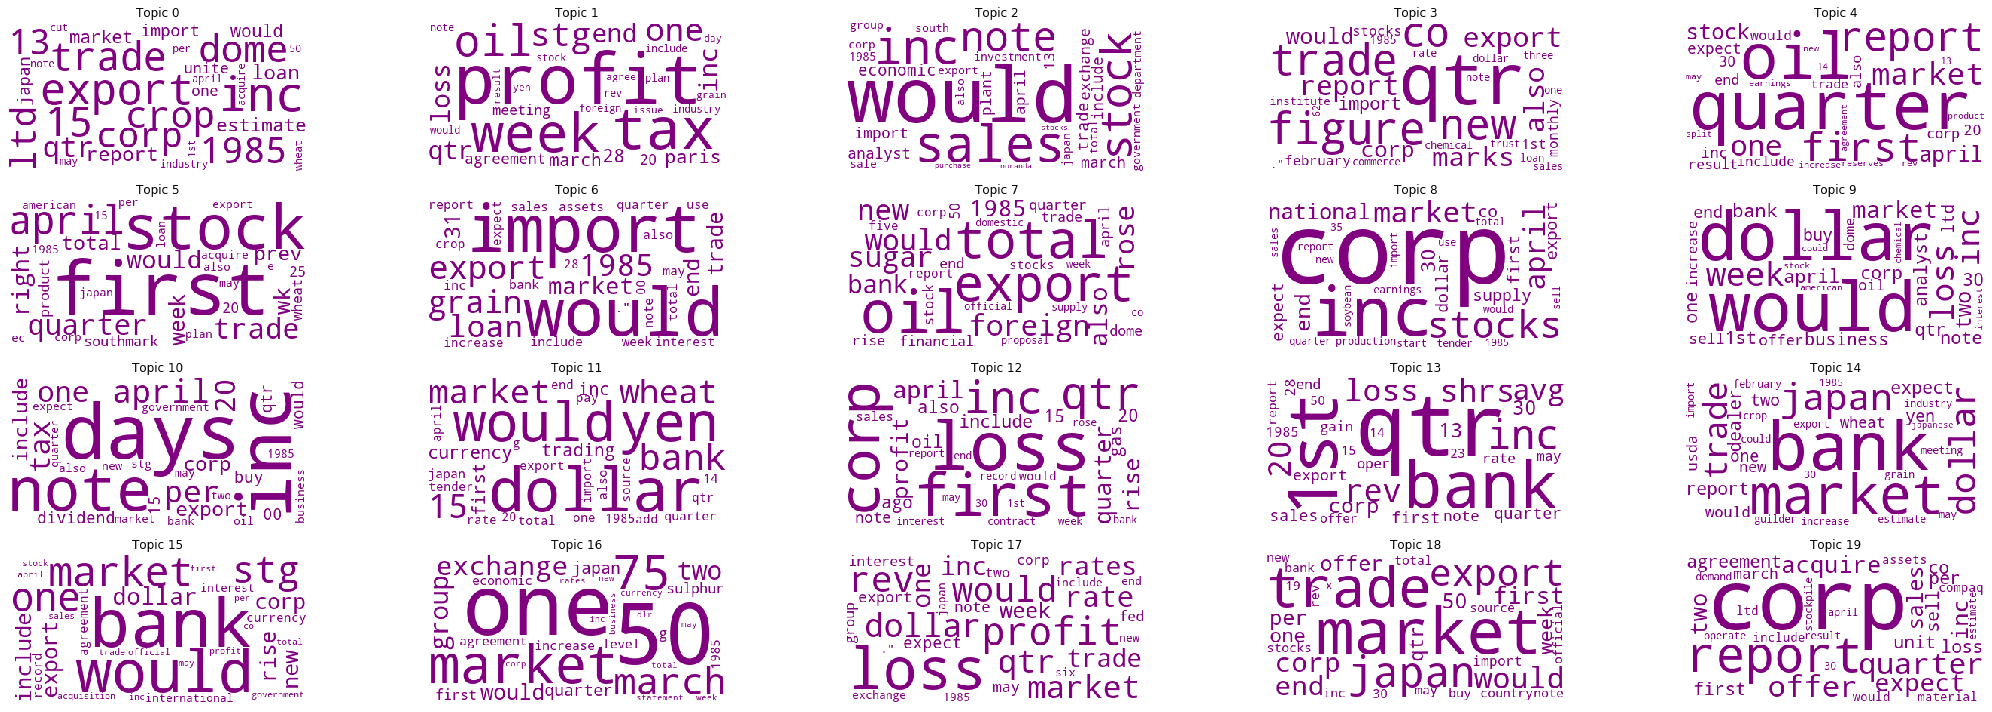

In [104]:
import matplotlib
import matplotlib.pylab as plt
import numpy as np
from wordcloud import WordCloud
from PIL import Image

topics = ldamodel.num_topics
cols = 5
rows = int(topics / cols)
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(30,10))
axs = axs.flatten()
 
def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'purple'

print(ldamodel.num_topics)
for i, t in enumerate(range(ldamodel.num_topics)):
 
    x = dict(ldamodel.show_topic(t, 30))
    im = WordCloud(background_color='white',
                   color_func=color_func,
                   random_state=0).generate_from_frequencies(x)
    axs[i].imshow(im)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t))
        
plt.tight_layout()
plt.show()